In [13]:
import numpy as np 
import pandas as pd 
from prettytable import PrettyTable

## Importing Necessary Libraries

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Text Processing Libraries

In [15]:
import re
import nltk
import string
import nlputils
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

## Data Visualization Libraries

In [16]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS

## Machine Learning Libraries

In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    f1_score, precision_score, recall_score, precision_recall_curve,
    fbeta_score, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Miscellaneous Libraries

In [18]:
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Extraction

In [19]:
# Path to the Kaggle input directory
kaggle_input_path = '/media/gamedisk/Code/College/Chat-toxicity/Data/jigsaw-toxic-comment-classification-challenge'

# List files in the Kaggle input directory
files_in_directory = os.listdir(kaggle_input_path)

# Extract and load the data from the Kaggle zip files
for file_name in files_in_directory:
    if file_name.endswith('.zip'):
        zip_file_path = os.path.join(kaggle_input_path, file_name)
        output_dir = '/media/gamedisk/Code/College/Chat-toxicity/Data/output'
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
            extracted_files = zip_ref.namelist()
            for extracted_file in extracted_files:
                complete_path = os.path.join(output_dir, extracted_file)
                print("Extracted:", complete_path)

# Load the data into a Pandas DataFrame
data = pd.read_csv("/media/gamedisk/Code/College/Chat-toxicity/Data/output/train.csv")
data.sample(5)

Extracted: /media/gamedisk/Code/College/Chat-toxicity/Data/output/sample_submission.csv


Extracted: /media/gamedisk/Code/College/Chat-toxicity/Data/output/test.csv
Extracted: /media/gamedisk/Code/College/Chat-toxicity/Data/output/test_labels.csv
Extracted: /media/gamedisk/Code/College/Chat-toxicity/Data/output/train.csv


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
133101,c812ebcd014cb54f,Thanks for the advice \n\nThank you for taking...,0,0,0,0,0,0
68055,b60bfca3190b7b5e,The only BULLSHIT on Olbermann's article comes...,1,0,1,0,0,0
118458,78eacfeaf7c73238,"SIOS\nI have been a Marine for ten years, and ...",0,0,0,0,0,0
137369,df02065cd5d2cb74,People Killed \n\nWhy does this article say 73...,0,0,0,0,0,0
105779,35f437fca3cc80bf,"""\n\n \n\n Dear Administrator,\n this mornin...",0,0,0,0,0,0


## Exploratory Data Analysis (EDA)

In [20]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [21]:
# Check for missing values
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

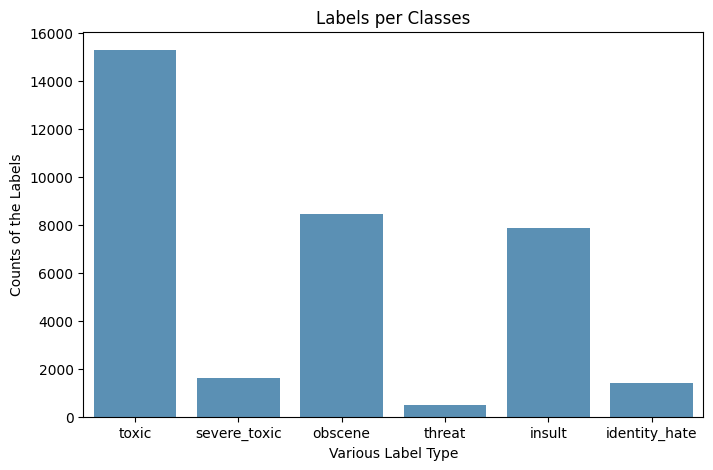

In [22]:
# Visualize label distribution
label_counts = data.iloc[:, 2:].sum()
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title("Labels per Classes")
plt.xlabel("Various Label Type")
plt.ylabel("Counts of the Labels")
plt.show()
df = pd.DataFrame(data)

## Data Cleaning

In [23]:
# Sample comment before cleaning
df['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [24]:
# Data cleaning functions
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]', r' ', x)

# Apply data cleaning functions to the 'comment_text' column
df['comment_text'] = df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

## Class Balancing

In [25]:
print(label_counts)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [26]:
Insulting_comment_df=df.loc[:,['id','comment_text','insult']]
Threatening_comment_df=df.loc[:,['id','comment_text','threat']]
IdentityHate_comment_df=df.loc[:,['id','comment_text','identity_hate']]
Obscene_comment_df=df.loc[:,['id','comment_text','obscene']]
Severetoxic_comment_df=df.loc[:,['id','comment_text','severe_toxic']]
Toxic_comment_df=df.loc[:,['id','comment_text','toxic']]

In [27]:
# Balancing the 'toxic' class
Toxic_comment_balanced_1 = Toxic_comment_df[Toxic_comment_df['toxic'] == 1].iloc[0:5000,:]
Toxic_comment_balanced_0 = Toxic_comment_df[Toxic_comment_df['toxic'] == 0].iloc[0:5000,:]
Toxic_comment_balanced = pd.concat([Toxic_comment_balanced_1,Toxic_comment_balanced_0])

# Balancing the 'severe_toxic' class
Severetoxic_comment_df_1 = Severetoxic_comment_df[Severetoxic_comment_df['severe_toxic'] == 1].iloc[0:1595,:]
Severetoxic_comment_df_0 = Severetoxic_comment_df[Severetoxic_comment_df['severe_toxic'] == 0].iloc[0:1595,:]
Severe_toxic_comment_balanced = pd.concat([Severetoxic_comment_df_1,Severetoxic_comment_df_0])

# Balancing the 'obscene' class
Obscene_comment_df_1 = Obscene_comment_df[Obscene_comment_df['obscene'] == 1].iloc[0:5000,:]
Obscene_comment_df_0 = Obscene_comment_df[Obscene_comment_df['obscene'] == 0].iloc[0:5000,:]
Obscene_comment_balanced = pd.concat([Obscene_comment_df_1,Obscene_comment_df_0])

# Balancing the 'threat' class
Threatening_comment_df_1 = Threatening_comment_df[Threatening_comment_df['threat'] == 1].iloc[0:478,:]
Threatening_comment_df_0 = Threatening_comment_df[Threatening_comment_df['threat'] == 0].iloc[0:1000,:]
Threatening_comment_balanced = pd.concat([Threatening_comment_df_1,Threatening_comment_df_0])

# Balancing the 'insult' class
Insulting_comment_df_1 = Insulting_comment_df[Insulting_comment_df['insult'] == 1].iloc[0:5000,:]
Insulting_comment_df_0 = Insulting_comment_df[Insulting_comment_df['insult'] == 0].iloc[0:5000,:]
Insulting_comment_balanced = pd.concat([Insulting_comment_df_1,Insulting_comment_df_0])

# Balancing the 'identity_hate' class
IdentityHate_comment_df_1 = IdentityHate_comment_df[IdentityHate_comment_df['identity_hate'] == 1].iloc[0:1405,:]
IdentityHate_comment_df_0 = IdentityHate_comment_df[IdentityHate_comment_df['identity_hate'] == 0].iloc[0:5000,:]
IdentityHate_comment_balanced = pd.concat([IdentityHate_comment_df_1,IdentityHate_comment_df_0])

In [28]:
combined_df = pd.concat([Severe_toxic_comment_balanced, Threatening_comment_balanced, Insulting_comment_balanced, IdentityHate_comment_balanced, Toxic_comment_balanced], ignore_index=True)
combined_df['combined_label'] = combined_df.iloc[:, 2:].sum(axis=1)


In [29]:
def cv_tf_train_test(dataframe, label, vectorizer, ngram):
    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]

    # Split our data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Using vectorizer and removing stopwords
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')

    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train)
    X_test_cv1  = cv1.transform(X_test)

    ## Machine learning models

    ## Logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)

    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)

    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)

    ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    ## Random Forest
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)

    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test),
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]}
    ## Saving f1 score results into a dataframe
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])

    return df_f1

## Word Cloud Visualization

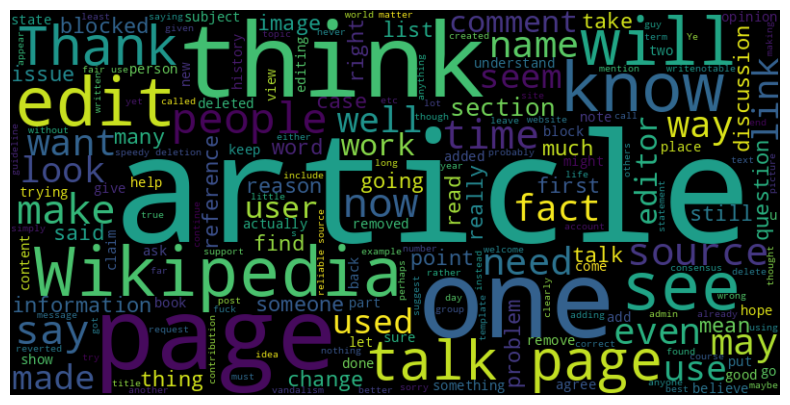

In [30]:
# Word frequency analysis
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(" ".join(data['comment_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

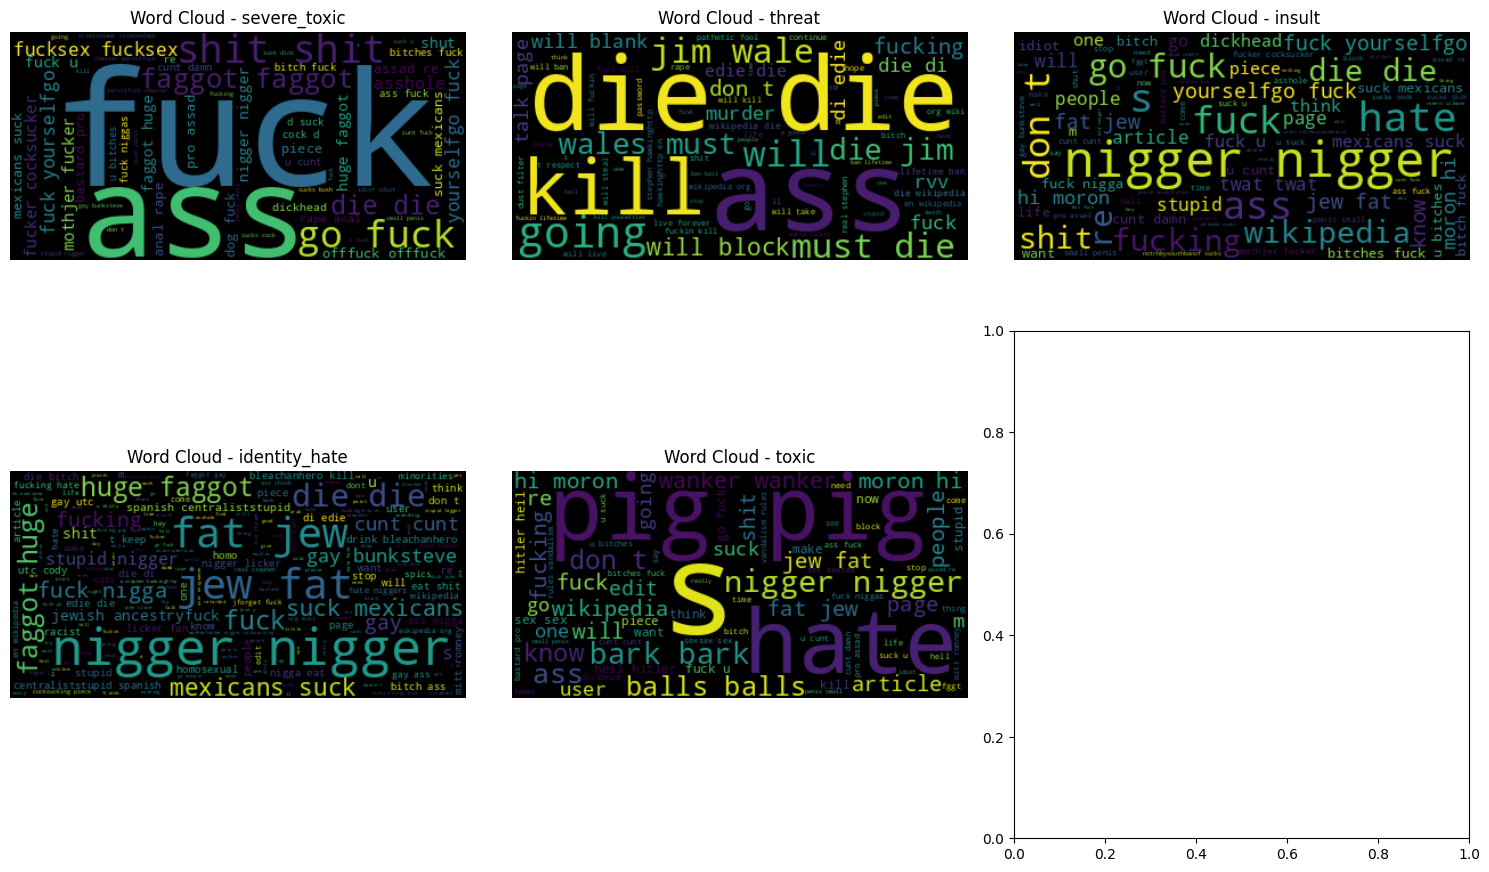

In [31]:
comment_types = ['severe_toxic', 'threat', 'insult', 'identity_hate', 'toxic']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, comment_type in enumerate(comment_types):

    comment_df = combined_df[combined_df[comment_type] == 1]
    wordcloud = WordCloud(width=400, height=200, background_color='black').generate(" ".join(comment_df['comment_text']))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud - {comment_type}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Text Vectorization and Model Training

In [32]:
# Model training and evaluation for 'severe_toxic' class
severe_toxic_comment_cv = cv_tf_train_test(Severe_toxic_comment_balanced, 'severe_toxic', TfidfVectorizer, (1,1))
severe_toxic_comment_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
severe_toxic_comment_cv

,F1 Score(severe_toxic)
Log Regression,0.940282
KNN,0.860192
BernoulliNB,0.790738
MultinomialNB,0.932377
SVM,0.937901
Random Forest,0.941176


In [33]:
# Model training and evaluation for 'threat' class
threat_comment_cv = cv_tf_train_test(Threatening_comment_balanced, 'threat', TfidfVectorizer, (1,1))
threat_comment_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
threat_comment_cv

,F1 Score(threat)
Log Regression,0.751092
KNN,0.718615
BernoulliNB,0.881481
MultinomialNB,0.798354
SVM,0.851562
Random Forest,0.853755


In [34]:
# Model training and evaluation for 'insult' class
insult_comment_cv = cv_tf_train_test(Insulting_comment_balanced, 'insult', TfidfVectorizer, (1,1))
insult_comment_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
insult_comment_cv

,F1 Score(insult)
Log Regression,0.902550
KNN,0.320661
BernoulliNB,0.776986
MultinomialNB,0.896299
SVM,0.906218
Random Forest,0.890821


In [35]:
# Model training and evaluation for 'identity_hate' class
identity_hatecomment_cv = cv_tf_train_test(IdentityHate_comment_balanced, 'identity_hate', TfidfVectorizer, (1,1))
identity_hatecomment_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
identity_hatecomment_cv

,F1 Score(identity_hate)
Log Regression,0.714706
KNN,0.271399
BernoulliNB,0.715976
MultinomialNB,0.564103
SVM,0.809399
Random Forest,0.846939


In [36]:

X = Toxic_comment_balanced.comment_text
y = Toxic_comment_balanced['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)
X_test_fit = tfv.transform(X_test)
randomforest = RandomForestClassifier(n_estimators=100, random_state=50)

randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1])

In [37]:
X_combined = combined_df.comment_text
y_combined = combined_df['combined_label']

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv_combined = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

X_train_combined_fit = tfv_combined.fit_transform(X_train_combined)
X_test_combined_fit = tfv_combined.transform(X_test_combined)

combined_label_model = SVC(kernel='linear', probability=True, random_state=42)
combined_label_model.fit(X_train_combined_fit, y_train_combined)

SVC(kernel='linear', probability=True, random_state=42)

In [44]:
accuracy = combined_label_model.score(X_test_combined_fit, y_test_combined)
print("Accuracy:", accuracy)

Accuracy: 0.9229779017378245


In [38]:
new_comments = ['go kill yourself','Have a great day','nig','COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK']
new_comments_vect = tfv_combined.transform(new_comments)
combined_label_model.predict_proba(new_comments_vect)[:, 1]

array([0.99716297, 0.34719231, 0.95810562, 0.95546281])

In [39]:
import joblib

joblib.dump(tfv_combined, 'tfidf_vectorizer.joblib')
joblib.dump(combined_label_model, 'toxicity_classification_model.joblib')

['toxicity_classification_model.joblib']